### Imports

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("husl")
sns.set_style("darkgrid")

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, Activation, ReLU
from keras.metrics import binary_accuracy, categorical_accuracy

### Load dataset

In [102]:
labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
data = pd.read_csv('data/FER2013/train.csv')

x = []
for index, row in data.iterrows():
    image_pixels = np.asarray(list(row['pixels'].split(' ')), dtype=np.uint8)
    image_pixels = image_pixels.reshape((48,48))
    x.append(image_pixels)
x = np.array(x)
x = np.expand_dims(x, 3)

y = data['emotion'].values

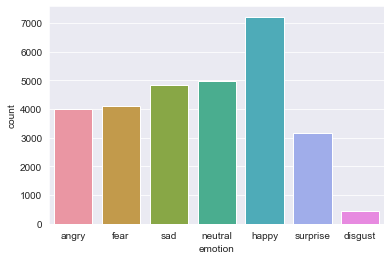

In [99]:
sns.countplot(data['emotion'].apply(lambda x : labels.get(x)));

From the above countplot graphic we can see that we have way more __*happy*__ samples than the rest of the other ones. Also, __*disgust*__ samples are almost 7 times less if compared to the category with more samples, __*happy*__.

We need to keep an eye on this imbalance on categories, once it may lead our model to bias towards happy labels and miss a lot of disgust samples.

### Models

####  Lenet